In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time 
from time import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation

In [2]:
dataset = pd.read_csv('datasets/dataset_normalizado.csv')
imputpd, preciopd = dataset[[i for i in dataset.columns if i!="Unnamed: 0" and i!='Close']], dataset['Close']


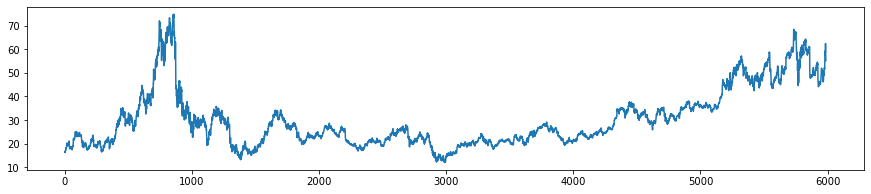

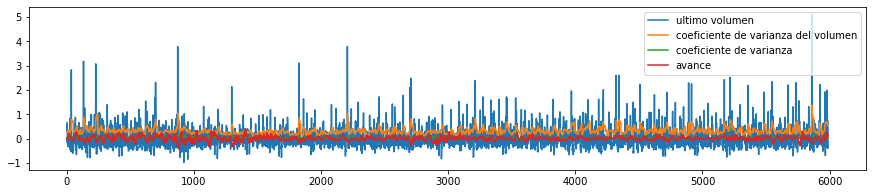

In [3]:
preciopd.plot(figsize=(15,3))
imputpd.plot(figsize=(15,3))

In [4]:
imput = imputpd.to_numpy()
precio = preciopd.to_numpy()

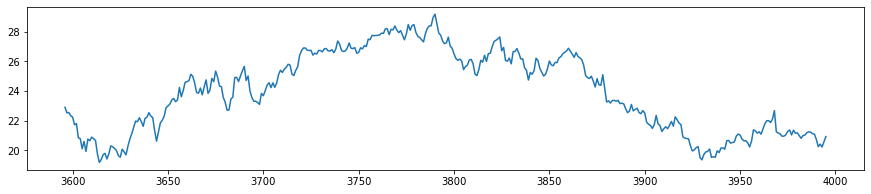

In [5]:
momento = random.randint(0,6000-400)
preciopd[momento:momento+400].plot(figsize=(15,3))
plt.show()

In [6]:
def crearModelo(entrada,salida,capasOcultas,nodos,activacion):
    
    model = Sequential()
    model.add(Dense(entrada, input_shape=(entrada,)))
    model.add(Activation('relu'))
    
    model.add(Dense(nodos, input_shape=(entrada,)))
    model.add(Activation('relu'))
    
    for i in range(capasOcultas-1):
        model.add(Dense(nodos, input_shape=(nodos,)))
        model.add(Activation('relu'))
        
    model.add(Dense(salida, input_shape=(nodos,)))
    model.add(Activation(activacion))
    
    model.compile(loss = 'mse', optimizer = 'adam', metrics=['accuracy'] )
    return model

def prediccion(modelos,modelo,entrada):
        
    neural_input = entrada
    output_prob = modelos[modelo].predict(neural_input,batch_size=400)
    output_prob = np.argmax(output_prob,axis =1)
    
    return output_prob

def cruzarModelos(modelos,modelo1,modelo2):
    
    pesos1 = modelos[modelo1].get_weights()
    pesos2 = modelos[modelo2].get_weights()

    pesosNuevos1 = pesos1
    pesosNuevos2 = pesos2

    gen = random.randint(0,len(pesosNuevos1)-1)

    pesosNuevos1[gen] = pesos2[gen]
    pesosNuevos2[gen] = pesos1[gen]
    
    return np.asarray([pesosNuevos1,pesosNuevos2])
    
def mutarModelo(pesos,cambio,ratioCambio):#,generation):
    
    # mutate each models weights
    for i in range(len(pesos)):
        for j in range(len(pesos[i])):
            if( random.uniform(0,1) > 1-cambio):
                change = random.uniform(-ratioCambio,ratioCambio)
                pesos[i][j] += change
        
    return pesos

def segmentoDataset(entrada,precio,size):
    
    momento = random.randint(0,np.shape(entrada)[0]-size)
    entrada = entrada[momento:momento+size]
    precio = precio[momento:momento+size]
    
    return momento,entrada,precio

def ejecutarAccion(modelo,accion,precio,billeteras,portafolios):
    
    #0  es mantenerse
    #1  es comprar
    #2  es vender
    
    if(accion == 0):
        return
    elif(accion == 1):
        if billeteras[modelo] < precio:
            return
        billeteras[modelo] = billeteras[modelo]-precio
        portafolios[modelo] = portafolios[modelo] + 1 
    else:
        if portafolios[modelo] == 0:
            return
        portafolios[modelo] = portafolios[modelo] - 1
        billeteras[modelo] = billeteras[modelo] + precio          
    return    

def evaluarAccion():
    return


In [11]:

total_models = 300 # numero de modelos a usar en cada generacion
mutation_size = 0.1 # que tanto se modificaran los pesos del modelo en la fase de mutacion
mutation_rate = 0.20 # cuantos pesos se modificaran de cada modelo
wallet_inicial = 1000 #cantidad de inicial de dinero que tiene cada bot
momentos = 1 # cuantos momentos se ban evaluar 
sizeMomento = 400 # longitud de la muestra
repeticiones_por_momento = 10; # cuantas veces se repetira cada momento

In [12]:
current_pool = []
fitness = []
wallet = []
portafolio = []
historico = []

for i in range(total_models):
    current_pool.append(crearModelo(4,3,1,9,'softmax'))
    wallet.append(wallet_inicial)
    fitness.append(0)
    portafolio.append(0)
    historico.append([])


generacion i=0 j=0
dinero: 1108.7300080000005


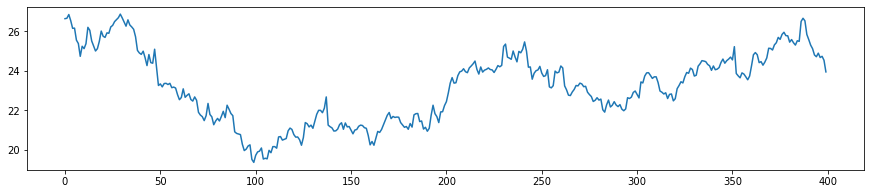

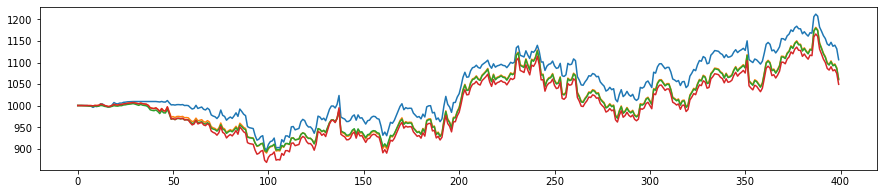

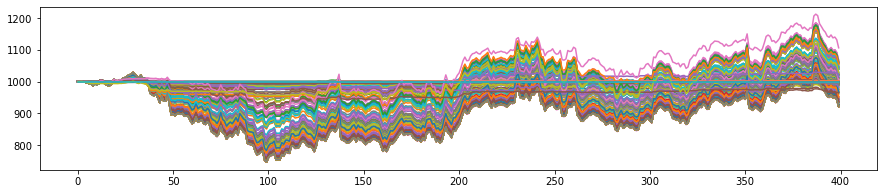

generacion i=0 j=1
dinero: 1058.6199960000001


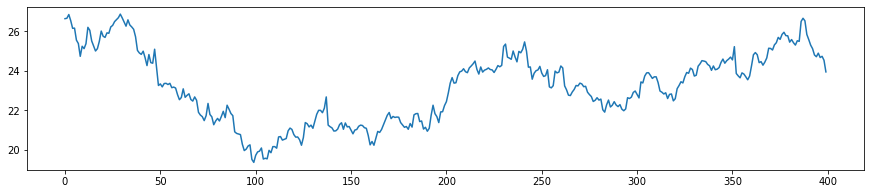

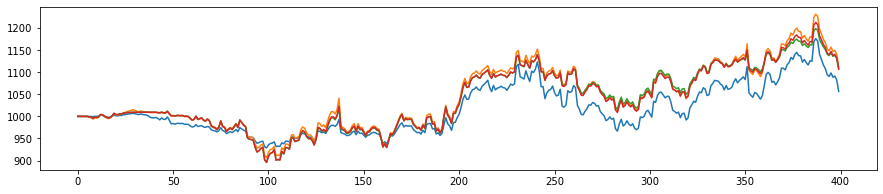

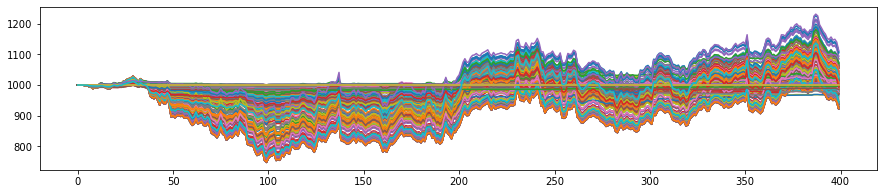

generacion i=0 j=2
dinero: 1155.2800120000004


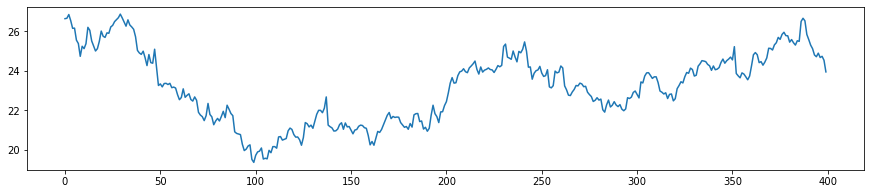

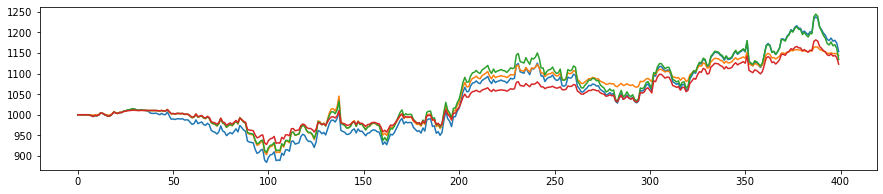

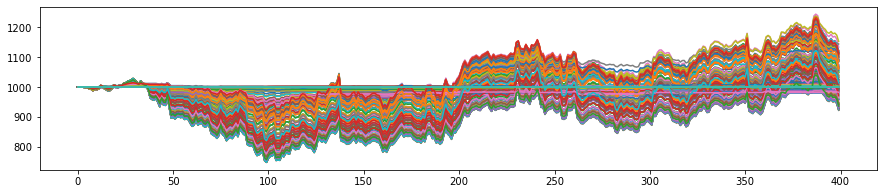

generacion i=0 j=3
dinero: 1155.2800120000004


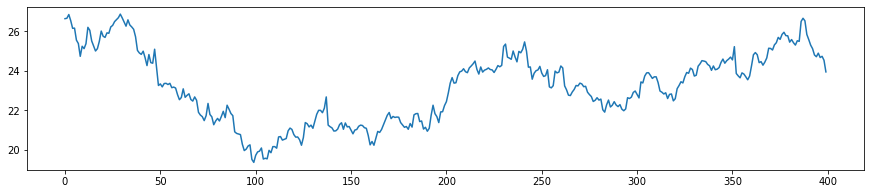

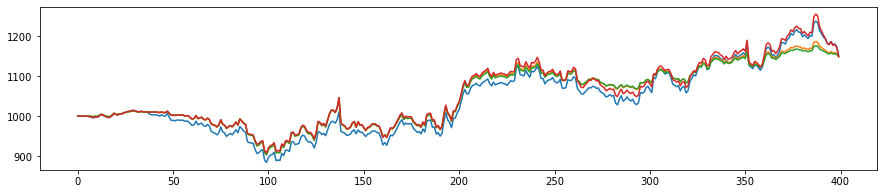

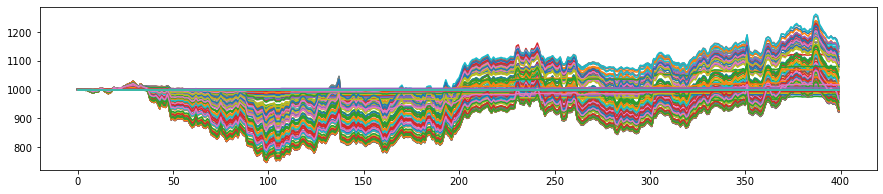

generacion i=0 j=4
dinero: 1157.8300110000007


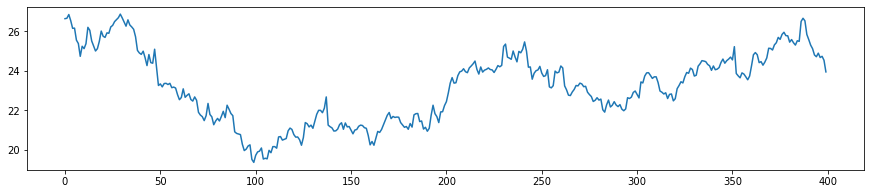

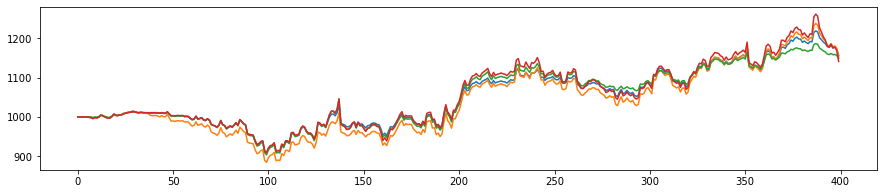

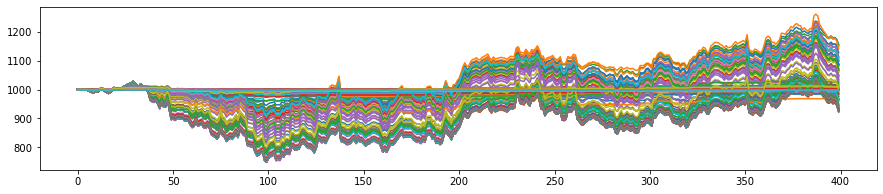

generacion i=0 j=5
dinero: 1157.8300110000007


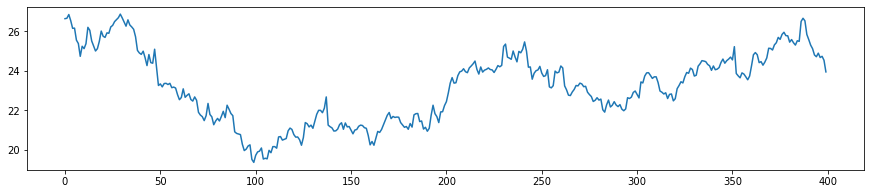

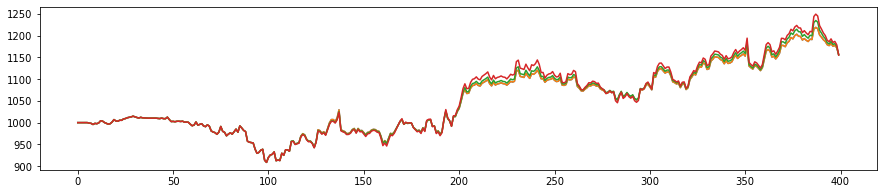

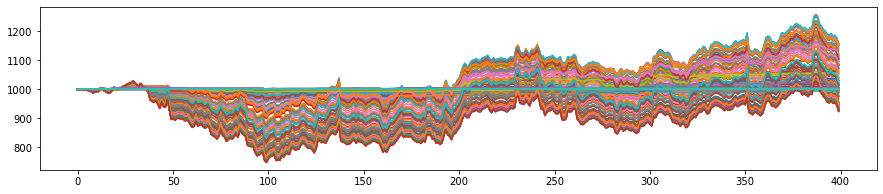

generacion i=0 j=6
dinero: 1167.1300110000009


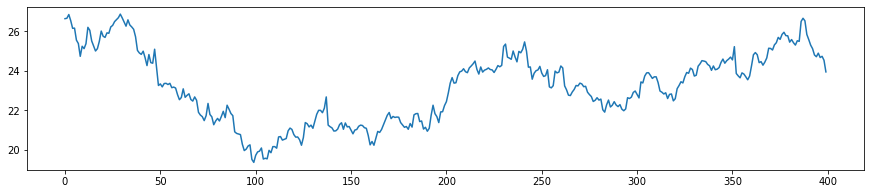

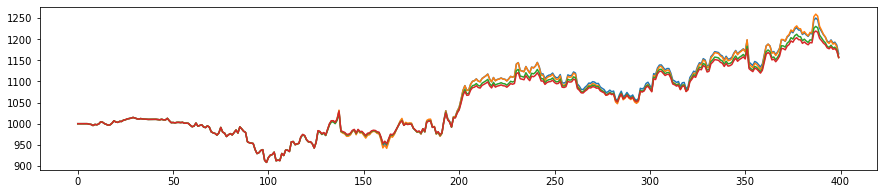

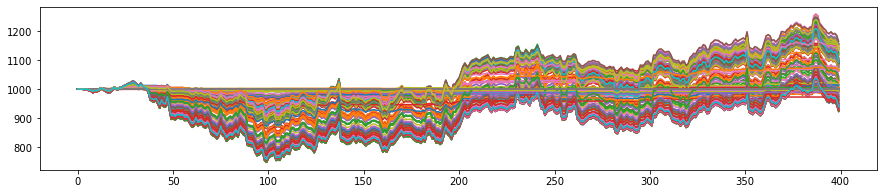

generacion i=0 j=7
dinero: 1167.1300110000009


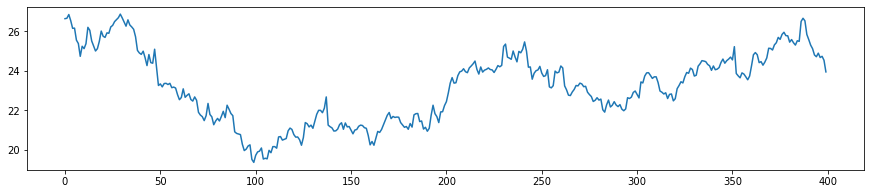

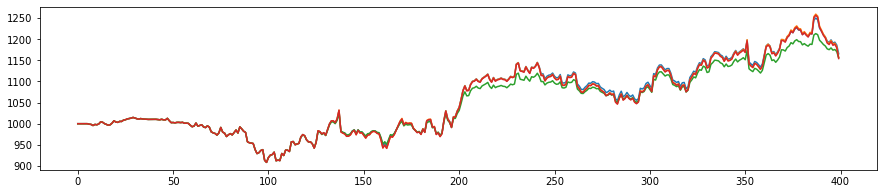

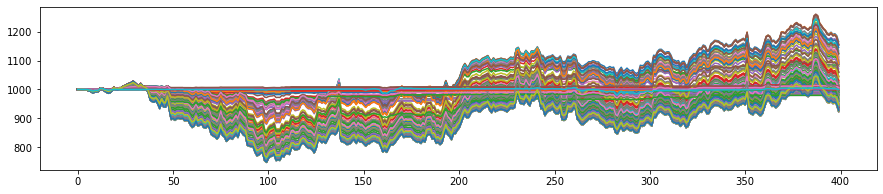

generacion i=0 j=8
dinero: 1167.6300110000006


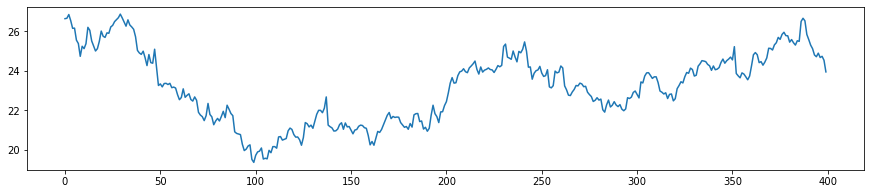

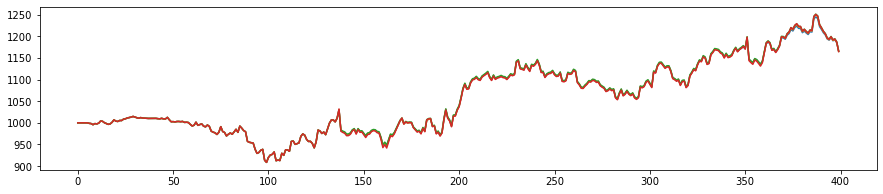

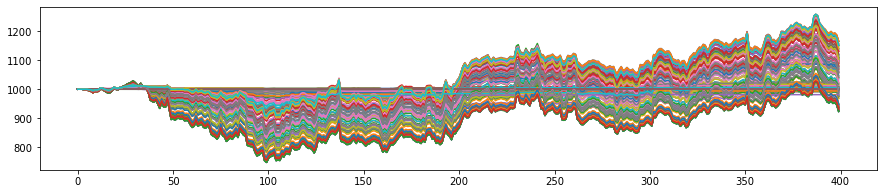

generacion i=0 j=9
dinero: 1167.6300110000006


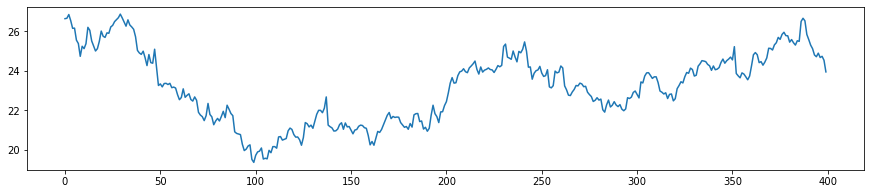

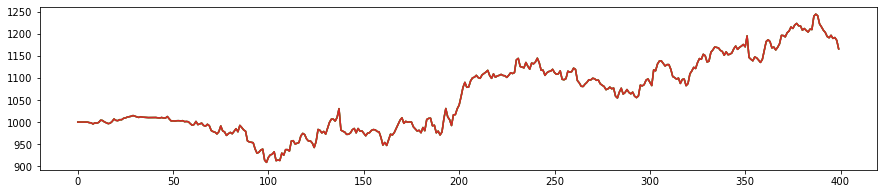

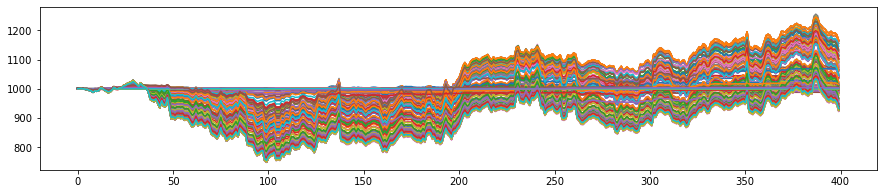

In [13]:
ultimaCompra = 0
ganancia = 0

for i in range(momentos):
    
    momento,datos,valor = segmentoDataset(imput,precio,sizeMomento)
    
    j=0
    for j in range(repeticiones_por_momento):
        k=0
        for k in range(total_models):
        
            acciones = prediccion(current_pool,k,datos)
            
            l=0
            for l in range(sizeMomento):      
                
                ejecutarAccion(k,acciones[l],valor[l],wallet,portafolio)
                historico[k].append(wallet[k]+(portafolio[k]*valor[l])) 
 
    #--------- evaluamos ------------------------------------------------   
               
                if acciones[l] == 1:
                    ultimaCompra = valor[l]
                elif acciones[l] == 2:
                    ganancia = 1 - (valor[l]/ultimaCompra)                
                fitness[k] += ganancia
        k=0
        for k in range(total_models):

            total_activos = wallet[k]+(portafolio[k]*(valor[sizeMomento-1]))

            if total_activos != wallet_inicial:
                fitness[k] += total_activos 
            else:
                fitness[k] +=  0

        mejores = np.argsort(fitness)

        print('generacion i='+str(i)+' j='+str(j))
        print('dinero: '+str(wallet[mejores[-1]]+(portafolio[mejores[-1]]*(precio[sizeMomento-1]))))
    

    #----------------------Reproduccion ---------------------------------------------------------------
        current_pool[0].set_weights(current_pool[mejores[-1]].get_weights())
        current_pool[1].set_weights(current_pool[mejores[-2]].get_weights())
        
        k=0
        for k in range(2,total_models,2):
            
            pesos = cruzarModelos(current_pool,mejores[-1],mejores[-2])
            
            pesosA = mutarModelo(pesos[0],mutation_rate,mutation_size)
            pesosB = mutarModelo(pesos[1],mutation_rate,mutation_size)
                
            current_pool[k].set_weights(pesosA)
            current_pool[k+1].set_weights(pesosB)
            
    #--------------------------------------imprimo los historicos----------------------------------------------
        historicoCopy = np.array(historico)

        plt.figure(figsize=(15,3))
        plt.plot(valor)
        plt.show()

        plt.figure(figsize=(15,3))
        plt.plot(historicoCopy[mejores[-1]])
        plt.plot(historicoCopy[mejores[-2]])
        plt.plot(historicoCopy[mejores[-3]])
        plt.plot(historicoCopy[mejores[-4]])
        plt.show()

        plt.figure(figsize=(15,3))
        plt.plot(historicoCopy.T)
        plt.show()
    
    
    #------------------------------------- reinicio wallets y demas --------------------------------------------
        historico = []
        
        k=0
        for k in range(total_models):    
            wallet[k]=wallet_inicial 
            fitness[k] = 0
            portafolio[k] = 0
            historico.append([])
    

# experimentar con los modelos

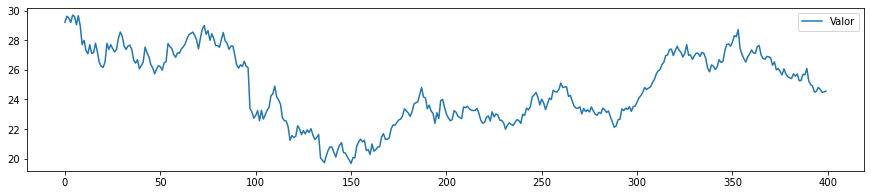

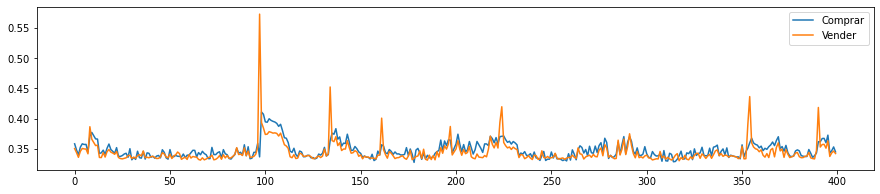

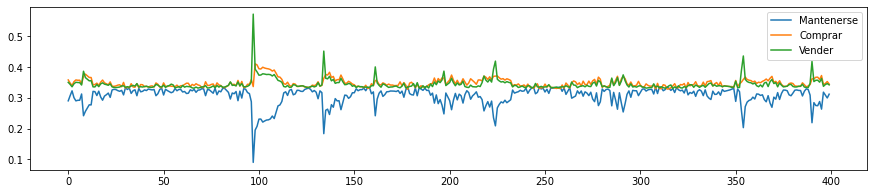

In [34]:
momento,datos,valor = segmentoDataset(imput,precio,sizeMomento)

plt.figure(figsize=(15,3))
plt.plot(valor)
plt.legend(['Valor'])
plt.show()

output_prob = current_pool[mejores[-1]].predict(datos,batch_size=400)

plt.figure(figsize=(15,3))
plt.plot(output_prob[:,1])
plt.plot(output_prob[:,2])
plt.legend(('Comprar', 'Vender'))
plt.show()


plt.figure(figsize=(15,3))
plt.plot(output_prob)
plt.legend(('Mantenerse', 'Comprar', 'Vender'))
plt.show()

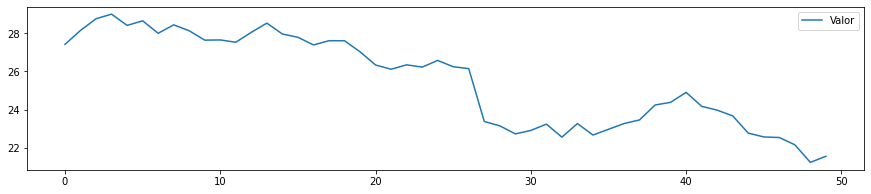

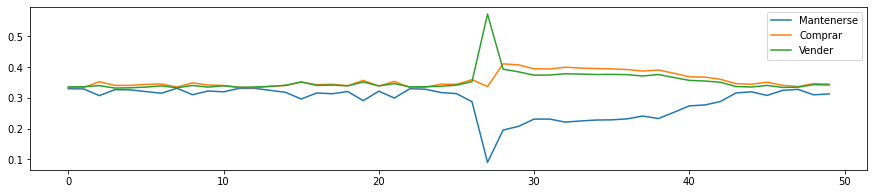

In [35]:
a = 70
b = 50

plt.figure(figsize=(15,3))
plt.plot(valor[a:a+b])
plt.legend(['Valor'])
plt.show()

plt.figure(figsize=(15,3))
plt.plot(output_prob[a:a+b,:])
plt.legend(('Mantenerse', 'Comprar', 'Vender'))
plt.show()